::: {.callout-note appearance="simple" title="Update Note" collapse="true"}

The majority of code and analysis in this post was originally written back in mid-2018 (in [this notebook](https://github.com/MattTriano/personal_site_public/blob/master/Crime_and_Prisons_part3.ipynb)). I've consolidated some cells, automated data retrieval, and added cell labels to make things render nicely, but otherwise I've left the work as-is. Compared to my current work products, this old code is very messy and unpolished, but like [Eric Ma](https://youtu.be/kETDOnnt5sc?t=530) (creator of the `networkx` graph data analysis package), I believe in showing newer data analysts and scientists I mentor that no one in this field started off with mastery of git, pandas, bash, etc, and that everyone who lasts loves to keep learning and improving.

After I integrate these old posts into this blog, I'll write an EDA post that starts from scratch using up-to-date data.
:::

# Imprisonment by Race

This notebook explores the racial breakdown of the 3 largest racial groups in US prisons (from 2006 to 2016): non-Hispanic white people, non-Hispanic black people, and Hispanic people.

In this notebook, I show that, over the entire span of data (2006-2016), black people are the largest racial prison population both in raw numbers and as a proportion of the total same-race US population.

**Average Number of Prisoners (from 2006-2016)**

| Race | Average Number in Prison |
| ------------- |:-------------:|
| Black | 551209 |
| White | 476136 |
| Hispanic | 336500 |

**Average Percent US Racial Population in Prison**

| Race | % of US Racial Pop. in Prison |
| ------------- | :------------- |
| Black | 1.440 % |
| White | 0.241 % |
| Hispanic | 0.656 % |

**Change in Average Percent US Racial Population in Prison**

| Race | Change in % of US Racial Pop. in Prison |
| ------------- | :------------- |
| Black | -0.406 % |
| White | -0.035 % |
| Hispanic | -0.113 % |

That is a fairly astonishing. A randomly selected black person is (on average) nearly 6 times as likely to be in prison as a randomly selected white person. There is clearly a statistically significant difference between these rates, so there are clearly more questions to answer.

## Data Source

This data is from file p16t03.csv of the Bureau of Justice Statistics [Prisoner Series](https://www.bjs.gov/index.cfm?ty=pbse&sid=40) data.

In [1]:
#| code-fold: true
#| code-summary: Imports, styling, and path definitions

import os
from urllib.request import urlretrieve
import zipfile

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.core.display import display, HTML
%matplotlib inline

# Importing modules from a visualization package.
# from bokeh.sampledata.us_states import data as states|
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.models import LinearColorMapper, ColorBar, BasicTicker

# styling
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format',lambda x: '%.3f' % x)
plt.rcParams['figure.figsize'] = 10,10

DATA_DIR_PATH = os.path.join("..", "010_crime_and_prisons_p1", 'data')
PRISON_DATA_DIR = os.path.join(DATA_DIR_PATH, 'prison')
POP_DATA_DIR = os.path.join(DATA_DIR_PATH, "population")

In [2]:
#| code-fold: true
#| code-summary: Loading and preprocessing the t03 dataset, Counts by Gender, Race, and Jurisdiction

CSV_PATH = os.path.join(PRISON_DATA_DIR, 'p16t03.csv')
race_sex_raw = pd.read_csv(CSV_PATH, 
                           encoding='latin1',
                           header=11, 
                           na_values=':',
                           thousands=r',')
race_sex_raw.dropna(axis=0, thresh=3, inplace=True)
race_sex_raw.dropna(axis=1, thresh=3, inplace=True)
race_sex_raw.dropna(axis=0, inplace=True)
fix = lambda x: x.split('/')[0]
race_sex_raw['Year'] = race_sex_raw['Year'].apply(fix)
race_sex_raw.columns = [x.split('/')[0] for x in race_sex_raw.columns]
race_sex_raw.set_index('Year', inplace=True)

display(race_sex_raw)

,Total,Federal,State,Male,Female,White,Black,Hispanic
Year,,,,,,,,
2006,1504598.000,173533.000,1331065.000,1401261.000,103337.000,507100.000,590300.000,313600.000
2007,1532851.000,179204.000,1353647.000,1427088.000,105763.000,499800.000,592900.000,330400.000
2008,1547742.000,182333.000,1365409.000,1441384.000,106358.000,499900.000,592800.000,329800.000
2009,1553574.000,187886.000,1365688.000,1448239.000,105335.000,490000.000,584800.000,341200.000
2010,1552669.000,190641.000,1362028.000,1447766.000,104903.000,484400.000,572700.000,345800.000
2011,1538847.000,197050.000,1341797.000,1435141.000,103706.000,474300.000,557100.000,347800.000
2012,1512430.000,196574.000,1315856.000,1411076.000,101354.000,466600.000,537800.000,340300.000
2013,1520403.000,195098.000,1325305.000,1416102.000,104301.000,463900.000,529900.000,341200.000
2014,1507781.000,191374.000,1316407.000,1401685.000,106096.000,461500.000,518700.000,338900.000


In [3]:
#| code-fold: true
#| code-summary: Mean annual inmate count by race

print('Average number of {:>8s} people in prison from 2006 to 2016: {:6.0f}'
      .format('black', race_sex_raw['Black'].mean()))
print('Average number of {:>8s} people in prison from 2006 to 2016: {:6.0f}'
      .format('white', race_sex_raw['White'].mean()))
print('Average number of {:>8s} people in prison from 2006 to 2016: {:6.0f}'
      .format('Hispanic', race_sex_raw['Hispanic'].mean()))

Average number of    black people in prison from 2006 to 2016: 551209
Average number of    white people in prison from 2006 to 2016: 476136
Average number of Hispanic people in prison from 2006 to 2016: 336500


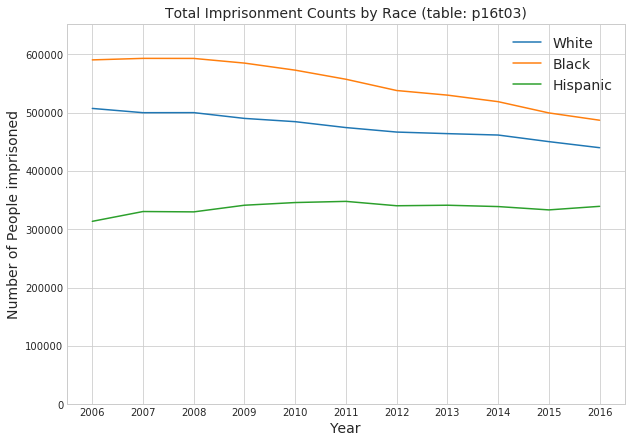

In [4]:
#| code-fold: true
#| code-summary: Plotting annual inmate counts by race

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(race_sex_raw['White'])
    ax.plot(race_sex_raw['Black'])
    ax.plot(race_sex_raw['Hispanic'])
    ax.set_title('Total Imprisonment Counts by Race (table: p16t03)',fontsize=14)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Number of People imprisoned', fontsize=14)
    ax.legend(fontsize=14)
    ax.set_ylim([0, 1.1*max([race_sex_raw['White'].max(), 
                             race_sex_raw['Black'].max(),
                             race_sex_raw['Hispanic'].max()])])

Looking at this plot of total imprisonment counts, we see that:
* At any given time, there are more non-Hispanic black people in prison than any other race.
* At any given time, there are more non-Hispanic white people than Hispanic people in prison.
* The numbers of imprisoned black people and white people decreased steadily from 2008 to 2016, while the number of imprisoned Hispanic people was been fairly flat over that time.

These numbers are raw counts, so they don't account for the fact that the fact that these races make up different proportions of the entire US population. This motivates questions like:

* What percent of the population of each race is in prison?

To answer that, I'll have to find population data broken down by race.


### Census Data

The Constitution requires that a full, national census is performed every 10 years that reaches every resident on American soil. This data is used to determine how much federal money is allocated to each district for things like schools, roadways, police, etc. and it determines how many congressional representatives will be allocated to each state. With the help of smaller surveys, the US Census bureau makes estimates of populations for the years between censuses.

[data source](https://www2.census.gov/programs-surveys/popest/tables/2010-2016/state/asrh/)

In [5]:
#| code-fold: true
#| code-summary: (NEW CODE) automating data collection

zip_pop_file_path = os.path.join(POP_DATA_DIR, "PEP_2016_PEPSR6H.zip")
url = "https://www2.census.gov/programs-surveys/popest/tables/2010-2016/state/asrh/PEP_2016_PEPSR6H.zip"
if not os.path.isfile(zip_pop_file_path):
    urlretrieve(url=url, filename=zip_pop_file_path)
    with zipfile.ZipFile(zip_pop_file_path, 'r') as zf:
        zf.extractall(POP_DATA_DIR)

In [6]:
#| code-fold: true
#| code-summary: Loading, filtering, and preprocessing annual national pop. estimates by race and ethnicity

CSV_PATH = os.path.join(POP_DATA_DIR, 'PEP_2016_PEPSR6H_with_ann.csv')
race_pop = pd.read_csv(CSV_PATH, header=[1], encoding='latin1')
print('\nInitial Data Format:')
display(race_pop.head(3))
# Only looking for national values
race_pop = race_pop[race_pop['Geography'] == 'United States']
# Eliminating the actual census values
race_pop = race_pop[~race_pop['Year'].str.contains('April')]
# Eliminating aggregated rows
race_pop = race_pop[race_pop['Hispanic Origin'] != 'Total']
# race_pop = race_pop[race_pop['Sex'] != 'Both Sexes']  # for later
race_pop = race_pop[~race_pop['Sex'].isin(['Male','Female'])]

drop_cols = ['Id', 'Id.1', 'Id.2', 'Id2', 'Id.3', 'Geography', 'Sex',
             'Race Alone - American Indian and Alaska Native', 'Race Alone - Asian',
             'Race Alone - Native Hawaiian and Other Pacific Islander']
race_pop.drop(drop_cols, axis=1, inplace=True)

# Reducing the size of long column names
col_map = {'Race Alone - Black or African American':'black_only_pop',
           'Race Alone - White': 'white_only_pop'}
race_pop.rename(col_map, axis=1, inplace=True)

print('\n\nData Format after Processing:')
display(race_pop.head(3))


Initial Data Format:


,Id,Year,Id.1,Sex,Id.2,Hispanic Origin,Id.3,Id2,Geography,Total,Race Alone - White,Race Alone - Black or African American,Race Alone - American Indian and Alaska Native,Race Alone - Asian,Race Alone - Native Hawaiian and Other Pacific Islander,Two or More Races
0,cen42010,"April 1, 2010 Census",female,Female,hisp,Hispanic,0100000US,nan,United States,24858794,21936806,1191984,702309,249346,85203,693146
1,cen42010,"April 1, 2010 Census",female,Female,nhisp,Not Hispanic,0100000US,nan,United States,132105418,100301335,19853611,1147502,7691693,246518,2864759
2,cen42010,"April 1, 2010 Census",female,Female,tothisp,Total,0100000US,nan,United States,156964212,122238141,21045595,1849811,7941039,331721,3557905




Data Format after Processing:


,Year,Hispanic Origin,Total,white_only_pop,black_only_pop,Two or More Races
24,"July 1, 2010",Hispanic,50754069,44855529,2343053,1392607
25,"July 1, 2010",Not Hispanic,258594124,197394319,38015461,5647760
33,"July 1, 2011",Hispanic,51906353,45841771,2410490,1445820


Based on the aggregation of the data I pulled, there is a rather vague 'Two or More Races' column. The prisoner data I've been working with has not differentiated between multiracial people and single-race people, rather, the prison data only breaks races down to non-Hispanic white, non-Hispanic black, and Hispanic. It's entirely possible for someone to be non-Hispanic, black, and multiracial, which would make it much more difficult and less accurate to use this population data with the prison data. Fortunately, however, the [documentation for the prison data](https://www.bjs.gov/content/pub/pdf/p16.pd)] includes footnotes indicating the data for white and black prison populations excludes persons of two or more races, so, conveniently, I must also exclude it.

In [7]:
#| code-fold: true
#| code-summary: Engineering counts for Hispanic origin (any race), Non Hispanic White only, and Non Hispanic Black only

race_pop.drop('Two or More Races', axis=1, inplace=True)
hisp = race_pop[race_pop['Hispanic Origin'] == 'Hispanic'].copy()
non_hisp = race_pop[race_pop['Hispanic Origin'] != 'Hispanic'].copy()
non_hisp.drop(['Hispanic Origin', 'Total'], axis=1, inplace=True)
hisp.drop(['white_only_pop','black_only_pop', 'Hispanic Origin'], axis=1, inplace=True)
hisp.rename({'Total':'Hispanic_pop'}, axis=1, inplace=True)
us_race_pop = hisp.merge(non_hisp, on=['Year'])
fix_yr = lambda x: x.split(' ')[-1]
us_race_pop['Year'] = us_race_pop['Year'].apply(fix_yr)
us_race_pop.set_index('Year', inplace=True)

display(us_race_pop.head(3))

,Hispanic_pop,white_only_pop,black_only_pop
Year,,,
2010,50754069,197394319,38015461
2011,51906353,197519026,38393758
2012,52993496,197701109,38776276


This provides population data from 2010 on, but not for the earlier years. To deal with earlier years, I need to handle another data set.

[data source](https://www.census.gov/data/tables/time-series/demo/popest/intercensal-2000-2010-national.html)

In [8]:
#| code-fold: true
#| code-summary: (NEW CODE) automating data collection

pop_file_path = os.path.join(POP_DATA_DIR, "us-est00int-02.xls")
url = "https://www2.census.gov/programs-surveys/popest/tables/2000-2010/intercensal/national/us-est00int-02.xls"
if not os.path.isfile(pop_file_path):
    urlretrieve(url=url, filename=pop_file_path)

In [9]:
#| code-fold: true
#| code-summary: Loading, filtering, and preprocessing annual national pop. estimates by race and ethnicity

race_pop0010 = pd.read_excel(pop_file_path, header=None)
print('\nInitial Data Format:')
display(race_pop0010.head())

race_pop0010.dropna(axis=0, thresh=6, inplace=True)
race_pop0010.drop([1],axis=1, inplace=True)
race_pop0010 = race_pop0010.T
race_pop0010.iloc[0,0] = 'Year'
race_pop0010.columns = race_pop0010.loc[0]
race_pop0010.drop(0, axis=0, inplace=True)
race_pop0010.dropna(axis=0, inplace=True)
race_pop0010['Year'] = race_pop0010['Year'].astype(int)
race_pop0010['Year'] = race_pop0010['Year'].astype(str)
race_pop0010.set_index('Year', inplace=True)

# Code to help drop columns I'm not interested in
drop_cols = []
drop_stumps = ['AIAN','Asian','NHPI', 'One Race', 'Two or']
for col in race_pop0010.columns:
    if any(x in col for x in drop_stumps):
        drop_cols.append(col)
race_pop0010.drop(drop_cols, axis=1, inplace=True)

# Code to facilitate merging this DataFrame with theother Population DataFrame
both0010 = race_pop0010.iloc[:,4:7].copy()
name_map = {'...White'  : 'white_only_pop',
            '...Black'  : 'black_only_pop',
            '.HISPANIC' : 'Hispanic_pop'}
both0010.rename(name_map, axis=1, inplace=True)
both0010 = both0010.astype(int)
pop_span = pd.concat([both0010, us_race_pop], join='inner')
race_sex_pop = race_sex_raw.join(pop_span)

print('\n\nData Format after Processing:')
display(race_pop0010.head())


Initial Data Format:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,table with row headers in column A and column ...,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN
1,Table 2. Intercensal Estimates of the Resident...,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN
2,"Sex, Race, and Hispanic Origin","April 1, 20001",Intercensal Estimates (as of July 1),nan,nan,nan,nan,nan,nan,nan,nan,nan,"April 1, 20102","July 1, 20103"
3,NaN,NaN,2000,2001.000,2002.000,2003.000,2004.000,2005.000,2006.000,2007.000,2008.000,2009.000,NaN,NaN
4,BOTH SEXES,281424600,282162411,284968955.000,287625193.000,290107933.000,292805298.000,295516599.000,298379912.000,301231207.000,304093966.000,306771529.000,308745538,309349689




Data Format after Processing:


,BOTH SEXES,..White,..Black,.NOT HISPANIC,...White,...Black,.HISPANIC,...White,...Black,MALE,..White,..Black,.NOT HISPANIC,...White,...Black,.HISPANIC,...White,...Black,FEMALE,..White,..Black,.NOT HISPANIC,...White,...Black,.HISPANIC,...White,...Black
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000,282162411,228530479,35814706,246500526,195701752,34405800,35661885,32828727,1408906,138443407,112710885,17027514,120101363,95778530,16340639,18342044,16932355,686875,143719004,115819594,18787192,126399163,99923222,18065161,17319841,15896372,722031
2001,284968955.000,230049196.000,36263029.000,247824859.000,195974813.000,34780280.000,37144096.000,34074383.000,1482749.000,139891492.000,113534140.000,17249678.000,120806379.000,95977450.000,16526760.000,19085113.000,17556690.000,722918.000,145077463.000,116515056.000,19013351.000,127018480.000,99997363.000,18253520.000,18058983.000,16517693.000,759831.000
2002,287625193.000,231446915.000,36684650.000,249007573.000,196140540.000,35130061.000,38617620.000,35306375.000,1554589.000,141230559.000,114269447.000,17454795.000,121412514.000,96101267.000,16697032.000,19818045.000,18168180.000,757763.000,146394634.000,117177468.000,19229855.000,127595059.000,100039273.000,18433029.000,18799575.000,17138195.000,796826.000
2003,290107933.000,232717191.000,37066096.000,250058504.000,196232760.000,35438251.000,40049429.000,36484431.000,1627845.000,142428897.000,114897973.000,17631747.000,121910556.000,96155748.000,16839027.000,20518341.000,18742225.000,792720.000,147679036.000,117819218.000,19434349.000,128147948.000,100077012.000,18599224.000,19531088.000,17742206.000,835125.000
2004,292805298.000,234120447.000,37510582.000,251303923.000,196461761.000,35797599.000,41501375.000,37658686.000,1712983.000,143828012.000,115664854.000,17856753.000,122592198.000,96345151.000,17022156.000,21235814.000,19319703.000,834597.000,148977286.000,118455593.000,19653829.000,128711725.000,100116610.000,18775443.000,20265561.000,18338983.000,878386.000


Now that I've got a full population data set, I can normalize the prisoner data.

In [10]:
#| code-fold: true
#| code-summary: Engineering percent of total group population incarcerated features

race_sex_pop.loc[:,'White_pct'] = race_sex_pop.loc[:,'White']\
                .divide(race_sex_pop.loc[:,'white_only_pop']) * 100
race_sex_pop.loc[:,'Black_pct'] = race_sex_pop.loc[:,'Black']\
                .divide(race_sex_pop.loc[:,'black_only_pop']) * 100
race_sex_pop.loc[:,'Hispanic_pct'] = race_sex_pop.loc[:,'Hispanic']\
                .divide(race_sex_pop.loc[:,'Hispanic_pop']) * 100

display(race_sex_pop)

,Total,Federal,State,Male,Female,White,Black,Hispanic,white_only_pop,black_only_pop,Hispanic_pop,White_pct,Black_pct,Hispanic_pct
Year,,,,,,,,,,,,,,
2006,1504598.000,173533.000,1331065.000,1401261.000,103337.000,507100.000,590300.000,313600.000,196832697,36520961,44606305,0.258,1.616,0.703
2007,1532851.000,179204.000,1353647.000,1427088.000,105763.000,499800.000,592900.000,330400.000,197011394,36905758,46196853,0.254,1.607,0.715
2008,1547742.000,182333.000,1365409.000,1441384.000,106358.000,499900.000,592800.000,329800.000,197183535,37290709,47793785,0.254,1.590,0.690
2009,1553574.000,187886.000,1365688.000,1448239.000,105335.000,490000.000,584800.000,341200.000,197274549,37656592,49327489,0.248,1.553,0.692
2010,1552669.000,190641.000,1362028.000,1447766.000,104903.000,484400.000,572700.000,345800.000,197394319,38015461,50754069,0.245,1.506,0.681
2011,1538847.000,197050.000,1341797.000,1435141.000,103706.000,474300.000,557100.000,347800.000,197519026,38393758,51906353,0.240,1.451,0.670
2012,1512430.000,196574.000,1315856.000,1411076.000,101354.000,466600.000,537800.000,340300.000,197701109,38776276,52993496,0.236,1.387,0.642
2013,1520403.000,195098.000,1325305.000,1416102.000,104301.000,463900.000,529900.000,341200.000,197777454,39135988,54064149,0.235,1.354,0.631
2014,1507781.000,191374.000,1316407.000,1401685.000,106096.000,461500.000,518700.000,338900.000,197902336,39507913,55189962,0.233,1.313,0.614


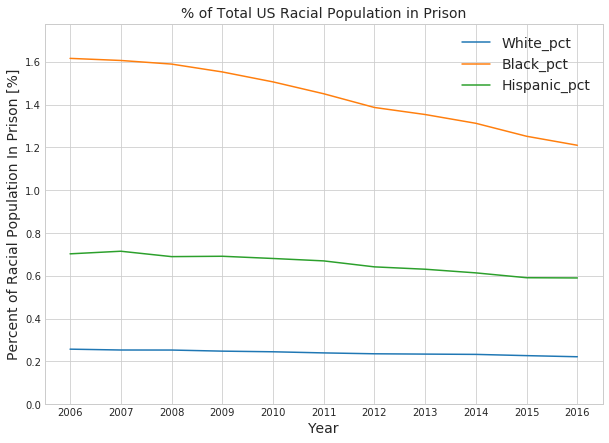

In [11]:
#| code-fold: true
#| code-summary: Plotting percent of total group population incarcerated by year

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(race_sex_pop['White_pct'])
    ax.plot(race_sex_pop['Black_pct'])
    ax.plot(race_sex_pop['Hispanic_pct'])
    ax.set_title('% of Total US Racial Population in Prison',fontsize=14)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Percent of Racial Population In Prison [%]', fontsize=14)
    ax.legend(fontsize=14)
    ax.set_ylim([0, 1.1*max([race_sex_pop['White_pct'].max(), 
                             race_sex_pop['Black_pct'].max(),
                             race_sex_pop['Hispanic_pct'].max()])])

In [12]:
#| code-fold: true
#| code-summary: Descriptive stats for percent of group incarcerated

print('Average percentage of total {:>8s} population in prison: {:0.3f}%'
      .format('black', race_sex_pop['Black_pct'].mean()))
print('Average percentage of total {:8s} population in prison: {:0.3f}%'
      .format('Hispanic', race_sex_pop['Hispanic_pct'].mean()))
print('Average percentage of total {:>8s} population in prison: {:0.3f}%'
      .format('white', race_sex_pop['White_pct'].mean()))

print('Change in percentage of total {:>8s} population in prison between 2006 to 2016: {:0.3f}%'
      .format('black', race_sex_pop['Black_pct']['2016'] - race_sex_pop['Black_pct']['2006']))
print('Change in percentage of total {:>8s} population in prison between 2006 to 2016: {:0.3f}%'
      .format('Hispanic', race_sex_pop['Hispanic_pct']['2016'] - race_sex_pop['Hispanic_pct']['2006']))
print('Change in percentage of total {:>8s} population in prison between 2006 to 2016: {:0.3f}%'
      .format('white', race_sex_pop['White_pct']['2016'] - race_sex_pop['White_pct']['2006']))

Average percentage of total    black population in prison: 1.440%
Average percentage of total Hispanic population in prison: 0.656%
Average percentage of total    white population in prison: 0.241%
Change in percentage of total    black population in prison between 2006 to 2016: -0.406%
Change in percentage of total Hispanic population in prison between 2006 to 2016: -0.113%
Change in percentage of total    white population in prison between 2006 to 2016: -0.035%


That's an extremely large difference. A randomly selected black person is nearly 6 times more likely to be in prison than a randomly selected white person and more than twice as likely as a randomly selected Hispanic person. 

That motivates the question: Why is there such a large difference between these populations? 

To investigate that question, it would be useful to investigate other questions, such as:
* Does the criminal justice system treat different racial groups differently?
* Is the average quality of education comparable for different racial populations?
* Is the distribution of quality of education comparable for different racial populations?
* Is the average quality of employment opportunity comparable for different racial populations?
* Is the distribution of quality of employment opportunities comparable for different racial populations?
* Is there a causal relationship between the pervasive housing segregation across the US and these disparities?
* What drove the significant reduction in the incarcerated proportion of black Americans from 2006-2016?

To Be Continued?